In [2]:
import os
import random
import torch
import numpy as np
from torchvision import models
from torch import nn, optim
from torch.optim import lr_scheduler

from data_loading import Data, default_imagenet_train_transform, default_imagenet_valid_transform, default_imagenet_test_transform
from model_training import train_model, plot_training_history
from model_testing import test_model, plot_examples

In [ ]:
random_seed = 42
random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
data_dir = 'C:/Users/weron/Pulpit/sem1/dl/proj1/archive'

In [ ]:
data = Data(
    data_dir, 
    train_transform = default_imagenet_train_transform(), 
    valid_transform = default_imagenet_valid_transform(), 
    test_transform = default_imagenet_test_transform()
)

## EfficientNet B0


In [6]:
model_ft = models.efficientnet_b0(weights='IMAGENET1K_V1')
num_ftrs =  model_ft.classifier[1].in_features
model_ft.classifier = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(num_ftrs, len(data.class_names))
)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [8]:
from torchsummary import summary

summary(model_ft, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

In [6]:
model_ft, train_loss, train_acc, val_loss, val_acc = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, data.dataloaders, device, num_epochs=20
)

Epoch 0/19
----------
train Loss: 1.1454 Acc: 0.6015
valid Loss: 0.4950 Acc: 0.8266

Epoch 1/19
----------
train Loss: 0.8179 Acc: 0.7112
valid Loss: 0.3918 Acc: 0.8609

Epoch 2/19
----------
train Loss: 0.7368 Acc: 0.7397
valid Loss: 0.3500 Acc: 0.8758

Epoch 3/19
----------
train Loss: 0.6869 Acc: 0.7584
valid Loss: 0.3240 Acc: 0.8849

Epoch 4/19
----------
train Loss: 0.6504 Acc: 0.7712
valid Loss: 0.3012 Acc: 0.8925

Epoch 5/19
----------
train Loss: 0.6241 Acc: 0.7797
valid Loss: 0.2960 Acc: 0.8949

Epoch 6/19
----------
train Loss: 0.5987 Acc: 0.7892
valid Loss: 0.2873 Acc: 0.8975

Epoch 7/19
----------
train Loss: 0.5723 Acc: 0.7984
valid Loss: 0.2769 Acc: 0.9014

Epoch 8/19
----------
train Loss: 0.5650 Acc: 0.8004
valid Loss: 0.2743 Acc: 0.9029

Epoch 9/19
----------
train Loss: 0.5572 Acc: 0.8043
valid Loss: 0.2715 Acc: 0.9034

Epoch 10/19
----------
train Loss: 0.5583 Acc: 0.8038
valid Loss: 0.2705 Acc: 0.9037

Epoch 11/19
----------
train Loss: 0.5493 Acc: 0.8062
valid Loss

In [ ]:
title = 'EfficientNet_B0_imagenet_transform'
folder = os.path.join('experiments', title)
os.makedirs(folder, exist_ok=True)

torch.save(model_ft.state_dict(), os.path.join(folder, 'best_model.pt'))

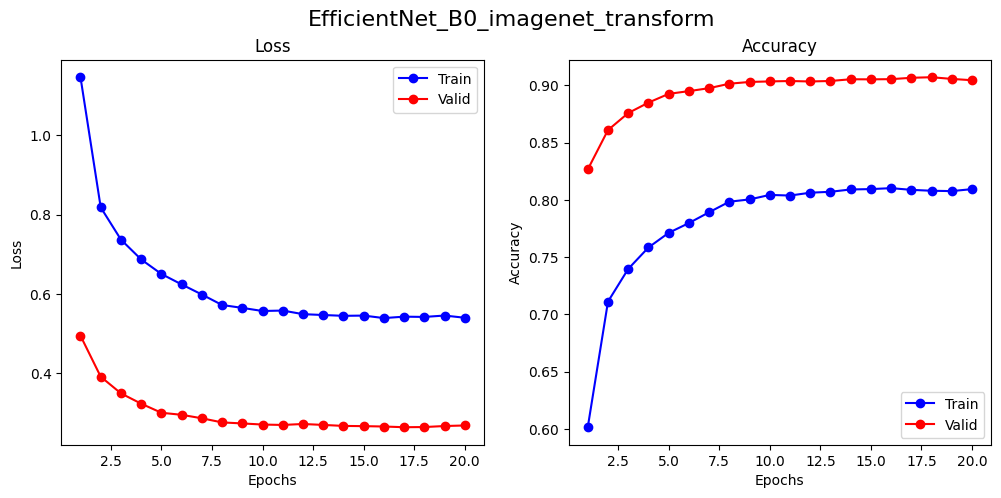

In [8]:
plot_training_history(train_loss, train_acc, val_loss, val_acc, title, folder)

In [9]:
test_model(model_ft, data.dataloaders['test'], device, folder)

Accuracy: 0.9043

Classification Report:
              precision    recall  f1-score   support

    airplane       0.94      0.94      0.94      9000
  automobile       0.89      0.87      0.88      9000
        bird       0.94      0.91      0.92      9000
         cat       0.87      0.87      0.87      9000
        deer       0.88      0.88      0.88      9000
         dog       0.84      0.86      0.85      9000
        frog       0.95      0.97      0.96      9000
       horse       0.93      0.92      0.93      9000
        ship       0.93      0.93      0.93      9000
       truck       0.86      0.88      0.87      9000

    accuracy                           0.90     90000
   macro avg       0.90      0.90      0.90     90000
weighted avg       0.90      0.90      0.90     90000



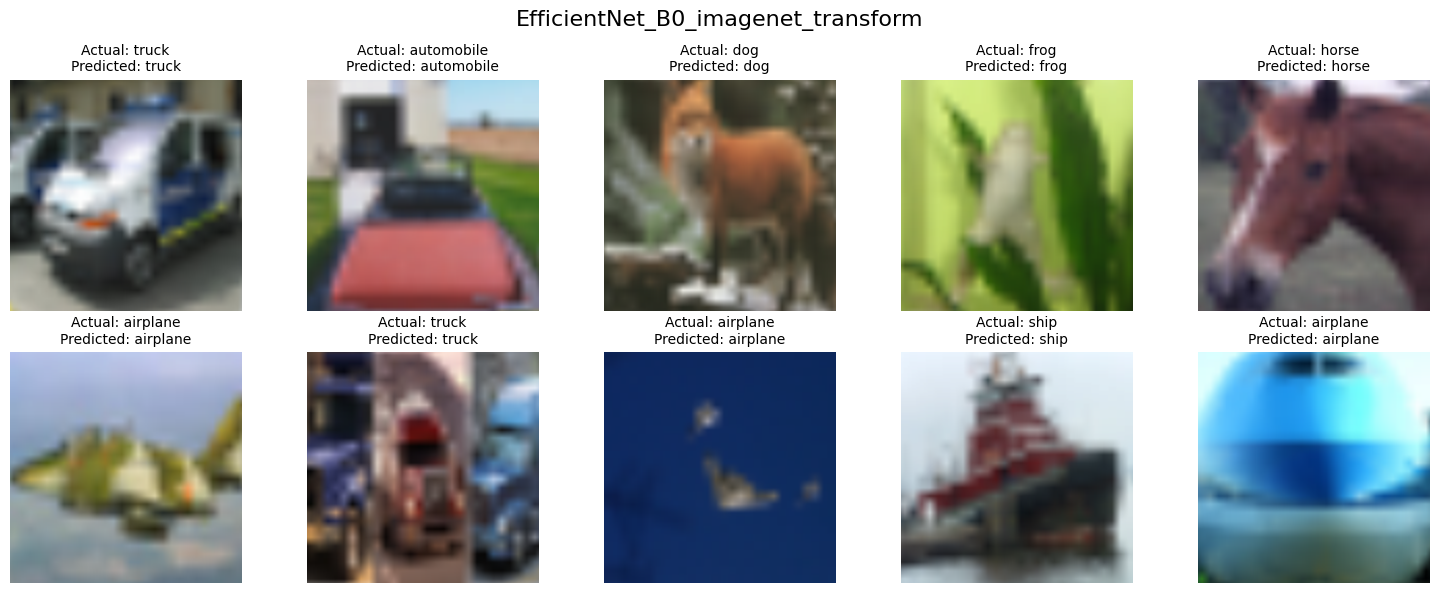

In [10]:
plot_examples(model_ft, data.dataloaders['test'], device, data.class_names,folder, title)

## EfficientNet B0 (frozen layers, but BN stats update)


In [11]:
model_ft = models.efficientnet_b0(weights='IMAGENET1K_V1')
for param in model_ft.parameters():
    param.requires_grad = False
num_ftrs =  model_ft.classifier[1].in_features
model_ft.classifier = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(num_ftrs, len(data.class_names))
)
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [12]:
model_ft, train_loss, train_acc, val_loss, val_acc = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, data.dataloaders, device, num_epochs=20
)

Epoch 0/19
----------
train Loss: 1.5789 Acc: 0.4663
valid Loss: 1.0655 Acc: 0.6541

Epoch 1/19
----------
train Loss: 1.3996 Acc: 0.5110
valid Loss: 1.0026 Acc: 0.6679

Epoch 2/19
----------
train Loss: 1.3628 Acc: 0.5221
valid Loss: 0.9848 Acc: 0.6691

Epoch 3/19
----------
train Loss: 1.3513 Acc: 0.5272
valid Loss: 0.9596 Acc: 0.6777

Epoch 4/19
----------
train Loss: 1.3473 Acc: 0.5261
valid Loss: 0.9493 Acc: 0.6805

Epoch 5/19
----------
train Loss: 1.3460 Acc: 0.5269
valid Loss: 0.9563 Acc: 0.6749

Epoch 6/19
----------
train Loss: 1.3325 Acc: 0.5297
valid Loss: 0.9450 Acc: 0.6792

Epoch 7/19
----------
train Loss: 1.3361 Acc: 0.5297
valid Loss: 0.9399 Acc: 0.6828

Epoch 8/19
----------
train Loss: 1.3346 Acc: 0.5298
valid Loss: 0.9332 Acc: 0.6853

Epoch 9/19
----------
train Loss: 1.3328 Acc: 0.5307
valid Loss: 0.9444 Acc: 0.6821

Epoch 10/19
----------
train Loss: 1.3279 Acc: 0.5336
valid Loss: 0.9316 Acc: 0.6878

Epoch 11/19
----------
train Loss: 1.3271 Acc: 0.5369
valid Loss

In [13]:
title = 'EfficientNet_B0_frozen_imagenet_transfrom'
folder = os.path.join('experiments', title)
os.makedirs(folder, exist_ok=True)

torch.save(model_ft.state_dict(), os.path.join(folder, 'best_model.pt'))

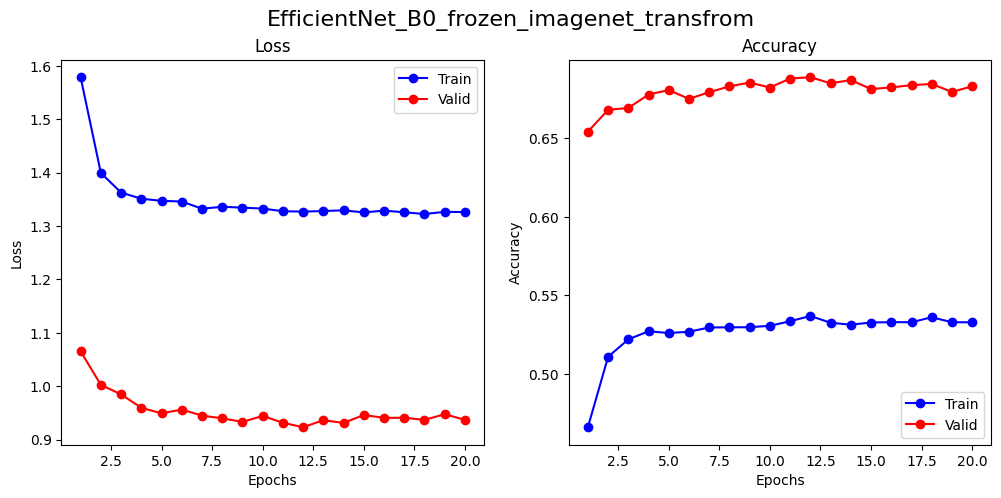

In [14]:
plot_training_history(train_loss, train_acc, val_loss, val_acc, title, folder)

In [15]:
test_model(model_ft, data.dataloaders['test'], device, folder)

Accuracy: 0.6869

Classification Report:
              precision    recall  f1-score   support

    airplane       0.72      0.79      0.75      9000
  automobile       0.69      0.74      0.72      9000
        bird       0.71      0.65      0.68      9000
         cat       0.57      0.58      0.57      9000
        deer       0.65      0.57      0.61      9000
         dog       0.57      0.59      0.58      9000
        frog       0.76      0.80      0.78      9000
       horse       0.70      0.76      0.73      9000
        ship       0.80      0.68      0.74      9000
       truck       0.70      0.71      0.71      9000

    accuracy                           0.69     90000
   macro avg       0.69      0.69      0.69     90000
weighted avg       0.69      0.69      0.69     90000



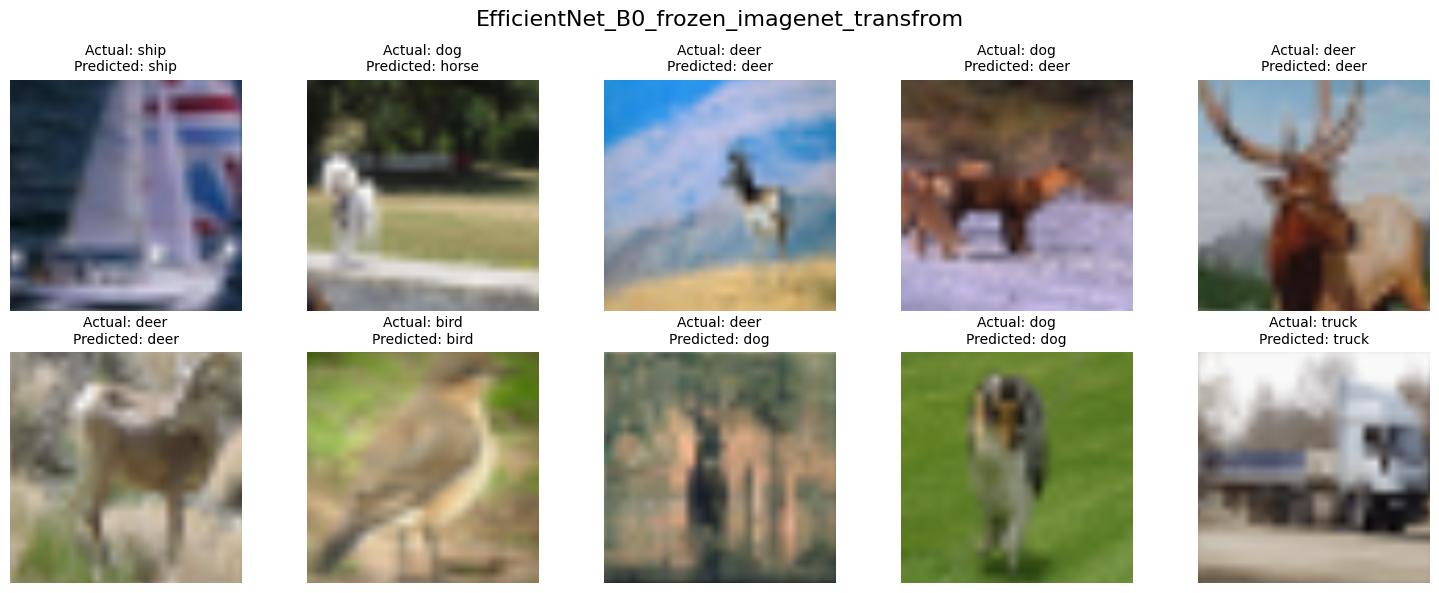

In [16]:
plot_examples(model_ft, data.dataloaders['test'], device, data.class_names,folder, title)

## EfficientNet B0 (full frozen layers)


In [17]:
model_ft = models.efficientnet_b0(weights='IMAGENET1K_V1')
for param in model_ft.parameters():
    param.requires_grad = False
num_ftrs =  model_ft.classifier[1].in_features
model_ft.classifier = nn.Sequential(
    nn.Dropout(p=0.2),
    nn.Linear(num_ftrs, len(data.class_names))
)
# Set BatchNorm/other norm layers to eval mode
model_ft.train(mode=False)  # Freezes BN stats
model_ft.classifier.train()  # Keep new head trainable
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [18]:
model_ft, train_loss, train_acc, val_loss, val_acc = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, data.dataloaders, device, num_epochs=20
)

Epoch 0/19
----------
train Loss: 1.5776 Acc: 0.4667
valid Loss: 1.0789 Acc: 0.6523

Epoch 1/19
----------
train Loss: 1.3939 Acc: 0.5139
valid Loss: 1.0103 Acc: 0.6625

Epoch 2/19
----------
train Loss: 1.3627 Acc: 0.5221
valid Loss: 0.9923 Acc: 0.6678

Epoch 3/19
----------
train Loss: 1.3498 Acc: 0.5267
valid Loss: 0.9662 Acc: 0.6737

Epoch 4/19
----------
train Loss: 1.3492 Acc: 0.5254
valid Loss: 0.9543 Acc: 0.6786

Epoch 5/19
----------
train Loss: 1.3453 Acc: 0.5256
valid Loss: 0.9473 Acc: 0.6814

Epoch 6/19
----------
train Loss: 1.3341 Acc: 0.5307
valid Loss: 0.9367 Acc: 0.6846

Epoch 7/19
----------
train Loss: 1.3320 Acc: 0.5301
valid Loss: 0.9306 Acc: 0.6865

Epoch 8/19
----------
train Loss: 1.3294 Acc: 0.5341
valid Loss: 0.9508 Acc: 0.6787

Epoch 9/19
----------
train Loss: 1.3330 Acc: 0.5297
valid Loss: 0.9504 Acc: 0.6801

Epoch 10/19
----------
train Loss: 1.3335 Acc: 0.5309
valid Loss: 0.9447 Acc: 0.6811

Epoch 11/19
----------
train Loss: 1.3264 Acc: 0.5326
valid Loss

In [19]:
title = 'EfficientNet_B0_full_frozen_imagenet_transfrom'
folder = os.path.join('experiments', title)
os.makedirs(folder, exist_ok=True)

torch.save(model_ft.state_dict(), os.path.join(folder, 'best_model.pt'))

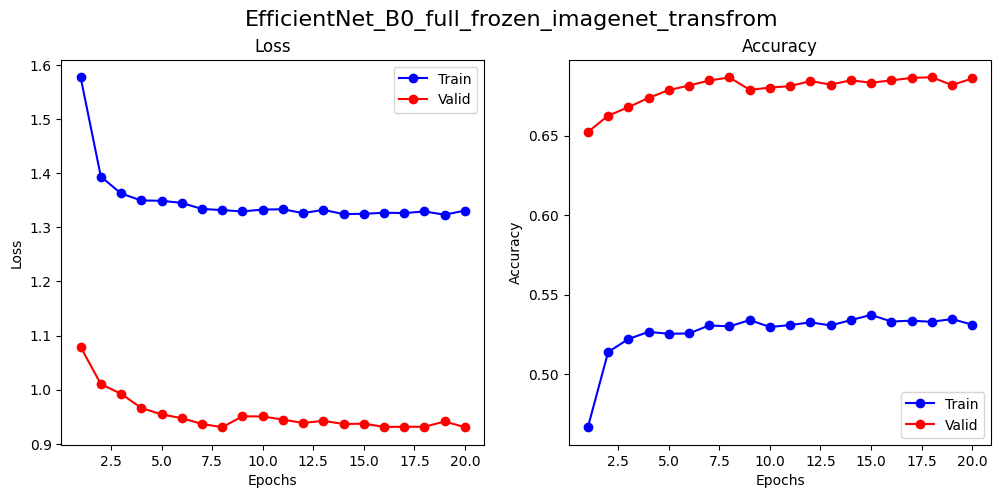

In [20]:
plot_training_history(train_loss, train_acc, val_loss, val_acc, title, folder)

In [21]:
test_model(model_ft, data.dataloaders['test'], device, folder)

Accuracy: 0.6857

Classification Report:
              precision    recall  f1-score   support

    airplane       0.72      0.78      0.75      9000
  automobile       0.69      0.75      0.72      9000
        bird       0.70      0.66      0.67      9000
         cat       0.58      0.55      0.56      9000
        deer       0.65      0.58      0.61      9000
         dog       0.56      0.62      0.59      9000
        frog       0.76      0.80      0.78      9000
       horse       0.72      0.74      0.73      9000
        ship       0.79      0.69      0.74      9000
       truck       0.71      0.69      0.70      9000

    accuracy                           0.69     90000
   macro avg       0.69      0.69      0.69     90000
weighted avg       0.69      0.69      0.69     90000



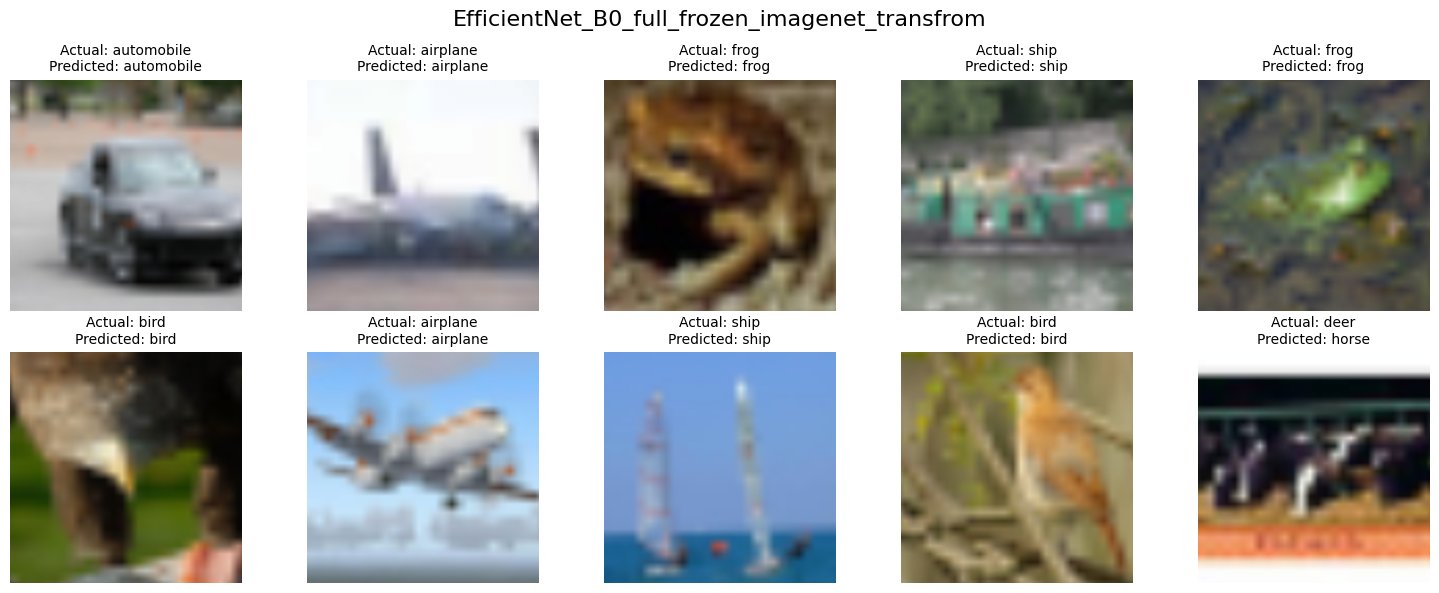

In [22]:
plot_examples(model_ft, data.dataloaders['test'], device, data.class_names,folder, title)